[![nbviewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Pyrcel/example_basic_run.ipynb)   
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=examples/PySDM_examples/Pyrcel/example_basic_run.ipynb)   
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Pyrcel/example_basic_run.ipynb)

### based on Fig. 1 from Wojciech Grabowski and Hanna Pawlowska 2023 (Geophysical Research Letters 50(3)) 'Adiabatic Evolution of Cloud Droplet Spectral Width: A New Look at an Old Problem'

https://doi.org/10.1029/2022GL101917

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install "open-atmos-jupyter-utils"
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [2]:
import PySDM
print(PySDM.__file__)

/home/agnieszka/Github/PySDM/PySDM/__init__.py


In [3]:
import numpy as np
from matplotlib import pyplot
import matplotlib.ticker as ticker
from open_atmos_jupyter_utils import show_plot

from PySDM import Formulae
from PySDM.physics import si
from PySDM.initialisation.spectra import Lognormal, Sum
from PySDM.products import (
    ParcelDisplacement, AmbientTemperature, AmbientRelativeHumidity
)

from PySDM_examples.Grabowski_and_Pawlowska_2023 import Settings, Simulation

In [4]:
settings_common={
    'dt' : 0.1 * si.s,
    'n_sd_per_mode' : (200,),
    'vertical_velocity' : 0.25 * si.m / si.s,
    'initial_pressure' : 900 * si.mbar,
    'initial_temperature' : 283 * si.K,
    'initial_relative_humidity' : .97,
    'displacement' : 1000 * si.m,
    'formulae' : Formulae(constants={'MAC': .3})
}
products=(
    ParcelDisplacement(
        name='z'),
    AmbientRelativeHumidity(
        name='S_max', unit='%', var='RH'),
    AmbientTemperature(
        name='T')
)

In [5]:
#pristine
settings = Settings(
    **settings_common,
    aerosol_modes_by_kappa = {
        1.28: Sum((
            Lognormal(norm_factor=125 / si.cm ** 3,m_mode=11 * si.nm,s_geom=1.2),
            Lognormal(norm_factor=65 / si.cm ** 3,m_mode=60 * si.nm,s_geom=1.7)
        ))
    }
)

simulation = Simulation(settings, products=products)
output_PRI = simulation.run()

In [6]:
#polluted
settings = Settings(
    **settings_common,
    aerosol_modes_by_kappa = {
        1.28: Sum((
            Lognormal(norm_factor=160 / si.cm ** 3,m_mode=29 * si.nm,s_geom=1.36),
            Lognormal(norm_factor=380 / si.cm ** 3,m_mode=71 * si.nm,s_geom=1.57)
        ))
    }
)

simulation = Simulation(settings, products=products)
output_POL = simulation.run()

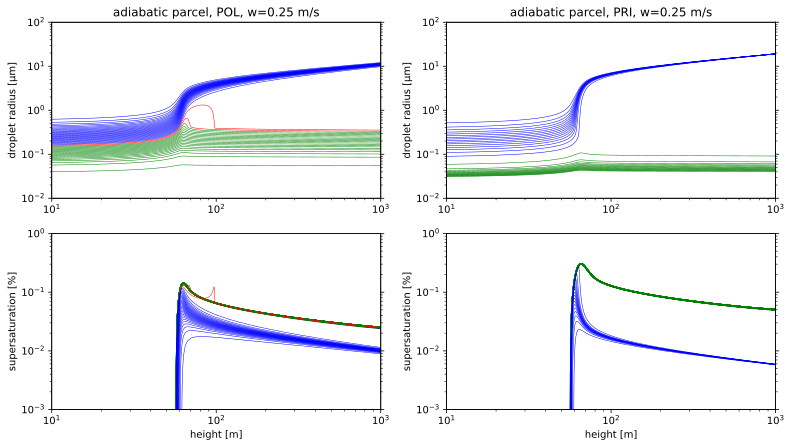

HTML(value="<a href='./fig1.pdf' target='_blank'>./fig1.pdf</a><br>")

: 

In [10]:
def plot_R(ax,output_vol,output_crit_vol,output_z,k):
    for drop_id, volume in enumerate(output_vol):
        if drop_id%k==0:
            if settings.formulae.trivia.radius(volume=np.asarray(volume))[10]>0.03*si.um:
                crit_volume=output_crit_vol[drop_id]
                if np.all(np.asarray(volume)<np.asarray(crit_volume)):
                    ax.plot(
                        output_z,
                        settings.formulae.trivia.radius(volume=np.asarray(volume)) / si.um,
                        linewidth=0.5,
                        color='green'
                    )
                elif np.asarray(volume)[-1]<np.asarray(crit_volume)[-1]:
                    ax.plot(
                        output_z,
                        settings.formulae.trivia.radius(volume=np.asarray(volume)) / si.um,
                        linewidth=0.5,
                        color='red'
                    )       
                else:
                    ax.plot(
                        output_z,
                        settings.formulae.trivia.radius(volume=np.asarray(volume)) / si.um,
                        linewidth=0.5,
                        color='blue'
                    )


def plot_S(ax,output_Seq,output_vol,output_crit_vol,output_z,k):
    for drop_id, S_eq in enumerate(output_Seq):
        if drop_id%k==0:
            volume=output_vol[drop_id]
            crit_volume=output_crit_vol[drop_id]
            if settings.formulae.trivia.radius(volume=np.asarray(volume)[10])>0.03*si.um:
                if np.all(np.asarray(volume)<np.asarray(crit_volume)):
                    ax.plot(
                        output_z,
                        (np.asarray(S_eq)-1)*100,        
                        color='green')
                elif np.asarray(volume)[-1]<np.asarray(crit_volume)[-1]:
                    ax.plot(
                        output_z,
                        (np.asarray(S_eq)-1)*100,
                        linewidth=0.5,
                        color='red')   
                else:
                    ax.plot(
                        output_z,
                        (np.asarray(S_eq)-1)*100,
                        linewidth=0.5,
                        color='blue')              
                    

fig, axs = pyplot.subplots(2, 2, sharey=False, figsize=(13, 7))
axS1 = axs[1,0]
axS2 = axs[1,1]
axS1.plot(output_POL['products']['z'],np.asarray(output_POL['products']['S_max'])-100, color='black')
axS2.plot(output_PRI['products']['z'],np.asarray(output_PRI['products']['S_max'])-100, color='black')
plot_S(axS1,output_POL['attributes']['equilibrium supersaturation'],output_POL['attributes']['volume'],output_POL['attributes']['critical volume'],output_POL['products']['z'],4)
plot_S(axS2,output_PRI['attributes']['equilibrium supersaturation'],output_PRI['attributes']['volume'],output_PRI['attributes']['critical volume'],output_PRI['products']['z'],4)

axR1 = axs[0,0]
axR2 = axs[0,1]
plot_R(axR1,output_POL['attributes']['volume'],output_POL['attributes']['critical volume'],output_POL['products']['z'],4)
plot_R(axR2,output_PRI['attributes']['volume'],output_PRI['attributes']['critical volume'],output_PRI['products']['z'],4)

axS1_ = axS1.twinx() 
axS2_ = axS2.twinx() 
axR1_ = axR1.twinx() 
axR2_ = axR2.twinx()
for ax in [axR1,axR2]:
    ax.set_ylabel('droplet radius [μm]')
axR1.set_title('adiabatic parcel, POL, w=0.25 m/s')
axR2.set_title('adiabatic parcel, PRI, w=0.25 m/s')
for ax in [axS1,axS2]:
    ax.set_xlabel('height [m]')
    ax.set_ylabel('supersaturation [%]') 
for ax in [axS1,axS1_,axS2,axS2_]:
    ax.set_ylim(0.001, 1)
    ax.set_xlim(10, 1000)
    ax.set_xscale('log')
    ax.set_yscale('log')
for ax in [axR1,axR1_,axR2,axR2_]:
    ax.set_xlim(10, 1000)
    ax.set_ylim(0.01, 100)
    ax.set_xscale('log')
    ax.set_yscale('log')
for ax in [axS1_,axS2_,axR1_,axR2_]:
    ax.yaxis.set_major_formatter(ticker.NullFormatter())
show_plot("fig1.pdf")